# ordinal mixed regression with brms

generate toy data and run brms with different ordinal regression models

1. ordinal targets: cumulative, sequential, adjacent category
2. longitudinal data: mixed models

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt

from importlib import reload
import datetime
from sklearn import preprocessing,metrics,model_selection
#import missingno as msn
from functools import reduce
from scipy import stats
import pyreadr

In [3]:
def PCM_numpy(theta,beta,betaind=[]):
    logits = theta[:,None]-beta[None, :]
    logits = np.concatenate([np.zeros((logits.shape[0],1)),logits],axis=-1)
    L = np.cumsum(logits, axis=-1)
    return np.exp(L)/(np.exp(L).sum(axis=-1, keepdims=True))

## 1. Ordinal Target data

generate data using adjacent category theory (Partial Credit Model) and artificial data and parameters

In [72]:
# generate toy ordinal regression data
random_state = np.random.RandomState(seed=23)

j = 100 #subject
t = 5 #sessions
m = 3 #covariates
n = 2 #scores

data_toy = pd.DataFrame(columns=['diagnosis_age','gender','score_ordinal3','score_ordinal5'],
                        index = pd.MultiIndex.from_product([[f'sub_{r}' for r in range(100,100+j)],np.linspace(0,10,t)],names=['participant',
                                                                                                                             'time_since_diagnosis']))
covs = ['diagnosis_age','gender','time_since_diagnosis']
data_toy['diagnosis_age'] = np.repeat(random_state.normal(60, 7, j),t)
data_toy['gender'] = np.repeat(random_state.choice([0,1],size=j),t)
data_toy['diagnosis_age_group'] = np.digitize(data_toy['diagnosis_age'], np.arange(55, 75, 10))
data_toy[['diagnosis_age']] = preprocessing.StandardScaler().fit_transform(data_toy[['diagnosis_age']])
beta = [np.linspace(0,10,3),np.linspace(0,12,5)] # map theta to scores via PCM
A = np.array([[4,-3],[-1,3],[1,1]]) # mxn map covs to theta

data_toy = data_toy.reset_index()

# get ability score
theta = (data_toy[covs] @ A).values
for si,score in enumerate(data_toy.filter(regex='score').columns):
    # get probabilities
    P = PCM_numpy(theta[:,si],beta[si])
    # get scores
    data_toy[score] = np.array([np.argmax(random_state.multinomial(1, p)) for p in P]).astype(int) + 1

#save data    
data_toy.to_csv('/scratch/c.c21013066/data/tutorial/brms/data/toy_data_ordinalreg.csv',index=False)

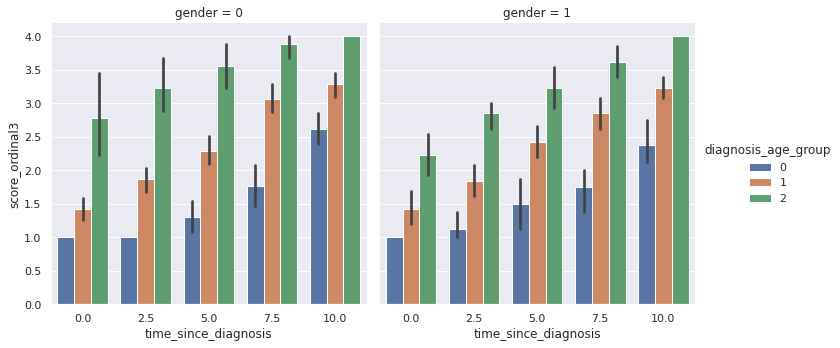

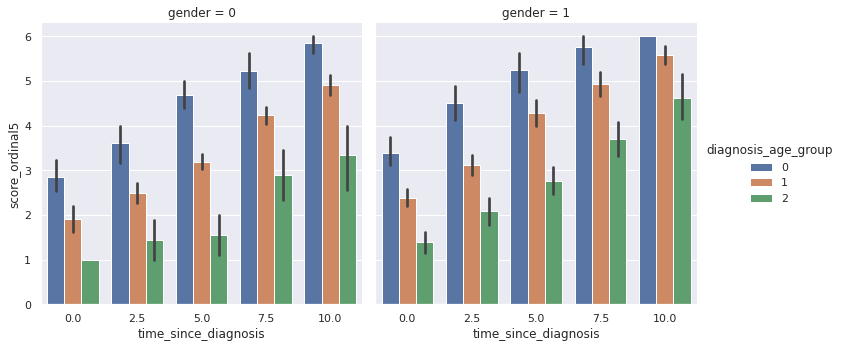

In [73]:
# plot responses
for si,score in enumerate(data_toy.filter(regex='score').columns):
    sns.set()
    sns.catplot(x='time_since_diagnosis',y=score,hue='diagnosis_age_group',col='gender',data=data_toy,kind='bar');

In [75]:
# now fit model in other notebook in R
# load model
models = ['ordreg_cum','ordreg_seq','ordreg_acat']
statistics = pd.DataFrame(columns=['MAE','MSE','R2'],index=models)
for model in models:
    print(model)
    coef = pd.read_csv(f'models/{model}/fixef.csv',index_col=0)
    pred = pd.read_csv(f'models/{model}/pred.csv',index_col=0)
    data = data_toy.merge(pred,right_index=True,left_index=True)
    data['score_ordinal3_pred'] = data.filter(regex='P').idxmax(axis=1).str.extract('(\d+)')
    for metric,func in zip(statistics.columns,[metrics.mean_absolute_error,metrics.mean_squared_error,metrics.r2_score]):
        statistics.loc[model,metric] = func(data['score_ordinal3'],data['score_ordinal3_pred'])
    coef['true'] = np.hstack([0,5,10,-1,4,1])
    print(coef)

ordreg_cum
                      Estimate  Est.Error      Q2.5      Q97.5  true
Intercept[1]          0.067913   0.242617 -0.402881   0.539348     0
Intercept[2]          4.673486   0.364312  3.987622   5.415374     5
Intercept[3]          9.899047   0.632822  8.706259  11.173213    10
gender               -1.285958   0.244903 -1.777322  -0.807989    -1
diagnosis_age         4.020799   0.269949  3.519215   4.576136     4
time_since_diagnosis  0.985016   0.064483  0.864327   1.115924     1
ordreg_seq
                      Estimate  Est.Error      Q2.5      Q97.5  true
Intercept[1]          0.051169   0.235889 -0.426066   0.511599     0
Intercept[2]          4.498348   0.395728  3.741627   5.285642     5
Intercept[3]          9.640789   0.692720  8.371540  11.077358    10
gender               -1.264552   0.248403 -1.758076  -0.779066    -1
diagnosis_age         3.940101   0.289347  3.396058   4.531986     4
time_since_diagnosis  0.961897   0.070779  0.830707   1.106701     1
ordreg_acat


In [76]:
statistics

,MAE,MSE,R2
ordreg_cum,0.729459,1.210421,-0.19787
ordreg_seq,0.725451,1.206413,-0.193903
ordreg_acat,0.727455,1.204409,-0.19192


## 2. Add group effect into toy data: mixed model
define three groups with differing intercept and slope

In [67]:
# generate toy ordinal regression data
random_state = np.random.RandomState(seed=23)

j = 100 #subject
t = 5 #sessions
m = 3 #covariates
n = 2 #scores

data_toy = pd.DataFrame(columns=['diagnosis_age','gender','score_ordinal3','score_ordinal5'],
                        index = pd.MultiIndex.from_product([[f'sub_{r}' for r in range(100,100+j)],np.linspace(0,10,t)],names=['participant',
                                                                                                                             'time_since_diagnosis']))
covs = ['diagnosis_age','gender','time_since_diagnosis']
data_toy['diagnosis_age'] = np.repeat(random_state.normal(60, 7, j),t)
data_toy['gender'] = np.repeat(random_state.choice([0,1],size=j),t)
data_toy['subtype'] = np.repeat(random_state.choice([0,1,2],size=j),t)
data_toy['diagnosis_age_group'] = np.digitize(data_toy['diagnosis_age'], np.arange(55, 75, 10))
data_toy[['diagnosis_age']] = preprocessing.StandardScaler().fit_transform(data_toy[['diagnosis_age']])
beta = [np.linspace(0,10,3),np.linspace(0,12,5)] # map theta to scores via PCM
A_0 = np.array([[4,-3],[-1,3],[1,1]]) # mxn map covs to theta
A_1 = np.array([[4,-3],[-1,3],[2,2]]) # mxn map covs to theta
A_2 = np.array([[4,-3],[-1,3],[-1,-1]]) # mxn map covs to theta
As = [A_0,A_1,A_2]

data_toy = data_toy.reset_index()

for sub in np.arange(3):
    group = data_toy[data_toy['subtype']==sub].index
    # get ability score
    theta = (data_toy.loc[group,covs] @ As[sub]).values
    for si,score in enumerate(data_toy.filter(regex='score').columns):
        # get probabilities
        P = PCM_numpy(theta[:,si],beta[si])
        # get scores
        data_toy.loc[group,score] = np.array([np.argmax(random_state.multinomial(1, p)) for p in P]).astype(int) + 1

#save data    
data_toy.to_csv('/scratch/c.c21013066/data/tutorial/brms/data/toy_data_ordinalreg_mixed.csv',index=False)

In [68]:
data_toy.groupby('subtype')['score_ordinal5'].mean()

subtype
0    3.463636
1    4.637838
2    1.368421
Name: score_ordinal5, dtype: float64

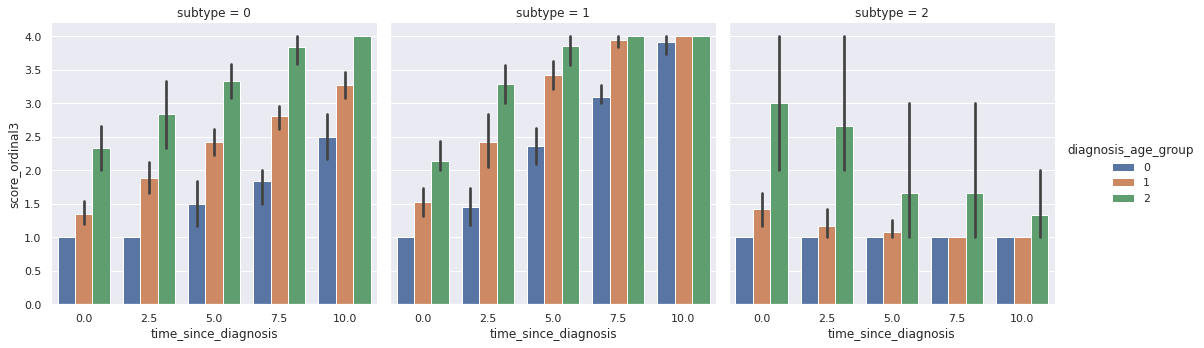

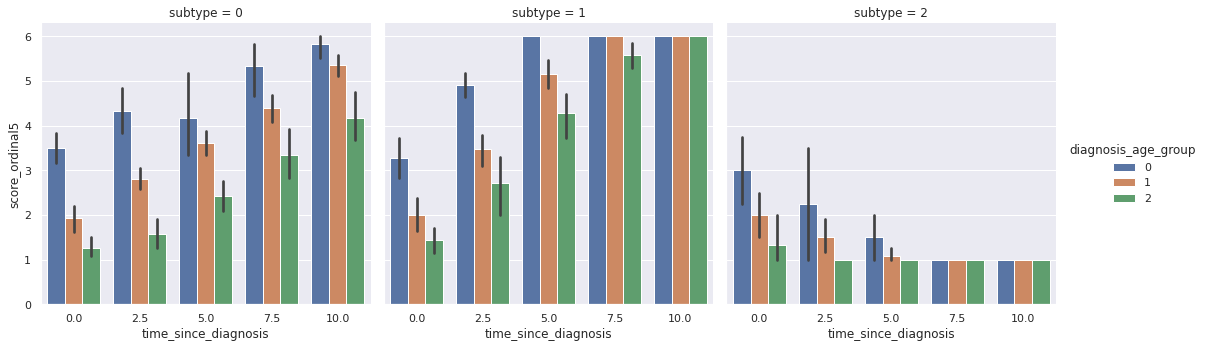

In [69]:
# plot responses
for si,score in enumerate(data_toy.filter(regex='score').columns):
    sns.set()
    sns.catplot(x='time_since_diagnosis',y=score,hue='diagnosis_age_group',col='subtype',data=data_toy,kind='bar');

In [93]:
# now fit model in other notebook in R
# load models
models = ['ordregmixed_cum','ordregmixed_seq','ordregmixed_acat']
statistics = pd.DataFrame(columns=['MAE','MSE','R2'],index=models)
for model in models:
    print(model)
    coef = pd.read_csv(f'models/{model}/fixef.csv',index_col=0)
    ran = pd.read_csv(f'models/{model}/coef.csv',index_col=0)
    pred = pd.read_csv(f'models/{model}/pred.csv',index_col=0)
    data = data_toy.merge(pred,right_index=True,left_index=True)
    data['score_ordinal3_pred'] = data.filter(regex='P').idxmax(axis=1).str.extract('(\d+)')
    for metric,func in zip(statistics.columns,[metrics.mean_absolute_error,metrics.mean_squared_error,metrics.r2_score]):
        statistics.loc[model,metric] = func(data['score_ordinal3'],data['score_ordinal3_pred'])
    coef['true'] = np.hstack([0,5,10,-1,4,1])
    print(coef)
    ran.columns = ran.columns.str.replace('subtype.','')
    ran = ran.filter(regex='(time_since_diagnosis|Intercept)')
    ran.index = ran.index.rename('subtype')
    ran['true.time_since_diagnosis'] = [1,2,-1]
    ran = ran.filter(regex='time_since_diagnosis')
    ran.columns = ran.columns.str.replace('.time_since_diagnosis','')
    print(ran)

ordregmixed_cum
                       Estimate  Est.Error      Q2.5      Q97.5  true
Intercept[1]          -0.148698   0.556840 -1.336253   0.953230     0
Intercept[2]           5.036465   0.676643  3.690327   6.379945     5
Intercept[3]          10.750365   0.975167  8.854108  12.697777    10
gender                -1.257995   0.285599 -1.804277  -0.703310    -1
diagnosis_age          4.181849   0.328701  3.569974   4.824549     4
time_since_diagnosis   1.037460   0.490874  0.107091   2.025025     1
         Estimate  Est.Error      Q2.5     Q97.5  true
subtype                                               
0        1.063994   0.087469  0.901487  1.247227     1
1        2.117410   0.170673  1.795735  2.465197     2
2       -0.993951   0.167950 -1.347305 -0.685973    -1
ordregmixed_seq
                       Estimate  Est.Error      Q2.5      Q97.5  true
Intercept[1]          -0.156916   0.611742 -1.460810   0.937277     0
Intercept[2]           4.894029   0.727133  3.471963   6.251321

/tmp/ipykernel_208505/2954760996.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  ran.columns = ran.columns.str.replace('subtype.','')
/tmp/ipykernel_208505/2954760996.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  ran.columns = ran.columns.str.replace('.time_since_diagnosis','')
/tmp/ipykernel_208505/2954760996.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  ran.columns = ran.columns.str.replace('subtype.','')
/tmp/ipykernel_208505/2954760996.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  ran.columns = ran.columns.str.replace('.time_since_diagnosis','')
/tmp/ipykernel_208505/2954760996.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  ran.columns = ran.columns.str.replace('subtype.','')
/tmp/ipykernel_208505/2954760

In [87]:
ran.filter(regex='(time_since_diagnosis|Intercept)').columns

Index(['Estimate.time_since_diagnosis', 'Est.Error.time_since_diagnosis',
       'Q2.5.time_since_diagnosis', 'Q97.5.time_since_diagnosis',
       'Estimate.Intercept.1.', 'Est.Error.Intercept.1.', 'Q2.5.Intercept.1.',
       'Q97.5.Intercept.1.', 'Estimate.Intercept.2.', 'Est.Error.Intercept.2.',
       'Q2.5.Intercept.2.', 'Q97.5.Intercept.2.', 'Estimate.Intercept.3.',
       'Est.Error.Intercept.3.', 'Q2.5.Intercept.3.', 'Q97.5.Intercept.3.'],
      dtype='object')

In [80]:
coef

,subtype.Estimate.time_since_diagnosis,subtype.Est.Error.time_since_diagnosis,subtype.Q2.5.time_since_diagnosis,subtype.Q97.5.time_since_diagnosis,subtype.Estimate.Intercept.1.,subtype.Est.Error.Intercept.1.,subtype.Q2.5.Intercept.1.,subtype.Q97.5.Intercept.1.,subtype.Estimate.Intercept.2.,subtype.Est.Error.Intercept.2.,...,subtype.Q2.5.Intercept.3.,subtype.Q97.5.Intercept.3.,subtype.Estimate.gender,subtype.Est.Error.gender,subtype.Q2.5.gender,subtype.Q97.5.gender,subtype.Estimate.diagnosis_age,subtype.Est.Error.diagnosis_age,subtype.Q2.5.diagnosis_age,subtype.Q97.5.diagnosis_age
0,1.028746,0.091987,0.858537,1.210431,-0.014818,0.305646,-0.616228,0.578003,-4.992190,0.507260,...,-12.322324,-8.820967,-1.223679,0.287885,-1.813781,-0.677936,4.050028,0.347625,3.411817,4.732829
1,2.048705,0.178665,1.716732,2.417344,-0.014426,0.358888,-0.732011,0.696472,-4.991798,0.539916,...,-12.371653,-8.818752,-1.223679,0.287885,-1.813781,-0.677936,4.050028,0.347625,3.411817,4.732829
2,-0.966419,0.166838,-1.312966,-0.655525,0.445268,0.515294,-0.455850,1.590173,-4.532104,0.640977,...,-11.909794,-8.321581,-1.223679,0.287885,-1.813781,-0.677936,4.050028,0.347625,3.411817,4.732829


In [83]:
statistics

,MAE,MSE,R2
ordregmixed_cum,0.801603,1.482966,-0.467589
ordregmixed_seq,0.805611,1.486974,-0.471555
ordregmixed_acat,0.805611,1.490982,-0.475522
